# Project: European Soccer Database

Files used in this notebook are the cleaned version of the original dataset, please refer to the notebook named "Data Cleaning" for more details or for generating the cleaned version from this link:
https://www.kaggle.com/aa4raf/data-cleaning

In [1]:
cd ../input/european-soccer-csv-files/

/kaggle/input/european-soccer-csv-files


**Note:** please pass the correct ffmpeg directory to view the animated bar chart race

In [2]:
#essential imports
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
# plt.rcParams['animation.ffmpeg_path'] = "C:\\ffmpeg\\bin\\ffmpeg.exe"
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

In [3]:
league_df = pd.read_csv('cleaned_league.csv')
match_stats_df = pd.read_csv('cleaned_stats.csv')
team_df = pd.read_csv('cleaned_team.csv')
team_attr_df = pd.read_csv('cleaned_team_attrs.csv')
player_df = pd.read_csv('cleaned_player.csv')

In [4]:
#the save and reload process seems to cancel some of the cleaning procedures that have to be repeated
match_stats_df.date = pd.to_datetime(match_stats_df.date)
team_attr_df.date = pd.to_datetime(team_attr_df.date)
def eval_goal_inf(goal_info):
    if pd.isna(goal_info) == False:
        return eval(goal_info)
    
match_stats_df.goals_info = match_stats_df.goals_info.apply(lambda val: eval_goal_inf(val))

### Q1: What teams improved the most over time in EPL?
The same analysis can be applied to other leagues and other seasons

> **steps are:**
>
> slice the match_stats_df according to the league of interest and for each season
>
> compare the home_team_goal and the away_team_goal and calculate 1 point for draw and 3 for win
>
> form a new data frame with date of the match as rows and teams as colums, this data frame can be used to visualize the points race through the same season for each league
>
> The final record of this dataframe (the final round of the season) would be stacked in the team dataframe so each record of it will have the team id, team_fifa_id, name, short name, total points in each season

In [5]:
league_df.name.values

array(['Belgium Jupiler League', 'England Premier League',
       'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A',
       'Netherlands Eredivisie', 'Poland Ekstraklasa',
       'Portugal Liga ZON Sagres', 'Scotland Premier League',
       'Spain LIGA BBVA', 'Switzerland Super League'], dtype=object)

In [6]:
EP_league = match_stats_df[match_stats_df.league_id == league_df[league_df.name == 'England Premier League'].id.values[0]]

In [7]:
EP_league.season.unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [8]:
EP_league_s01 = EP_league[EP_league.season == '2008/2009'].sort_values('date')

In [9]:
def calc_point(h_goals, a_goals, date, h_id, a_id, df):
    '''
    This function calculates teams' points according to the match scores. it assigns 3 points for win, 1 for draw and 0 for loss
    Args:
        h_goals -> goals of the home team
        a_goals -> goals of the away team
        date -> date of the match
        h_id -> home team id
        a_id -> away team id
        df -> empty data frame to stack the points of each week in the season    
    '''
    if h_goals > a_goals:
        df.loc[date, h_id] = 3
        df.loc[date, a_id] = 0
    elif a_goals > h_goals:
        df.loc[date, a_id] = 3
        df.loc[date, h_id] = 0
    else:
        df.loc[date, h_id] = 1
        df.loc[date, a_id] = 1

In [10]:
#empty df to records the points of each round in the season
EP_points_s01 = pd.DataFrame(index=EP_league_s01.date.unique())

In [11]:
#calculating the points
EP_league_s01.apply(lambda row: calc_point(row.home_team_goal, row.away_team_goal, row.date, row.home_team_api_id, row.away_team_api_id, EP_points_s01), axis=1);

In [12]:
#zeros for teams that didn't play in the early rounds or they lost
EP_points_s01.fillna(value=0, inplace=True)

In [13]:
#cumlate the points over the rounds
EP_points_s01 = EP_points_s01.cumsum(axis = 0)

In [14]:
#replace the team id with the team short name 
EP_points_s01.rename(columns=lambda val: team_df[team_df.team_api_id == val].team_short_name.values[0], inplace= True)

In [15]:
EP_points_s01.index.name = 'date';

I found that creating a bar chart race is very suitable for this case, so I searched for implementing it through this [reference](https://medium.com/dunder-data/create-a-bar-chart-race-animation-in-python-with-matplotlib-477ed1590096)
.The adopted part is the prepare_data function that expands the dataframe to achieve smoothness in the animation 

In [16]:
def prepare_data(df, steps=5):
    df = df.reset_index()
    df.index = df.index * steps
    last_idx = df.index[-1] + 1
    df_expanded = df.reindex(range(last_idx))
    df_expanded['date'] = df_expanded['date'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('date')
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_expanded = df_expanded.interpolate()
    df_rank_expanded = df_rank_expanded.interpolate()
    return df_expanded, df_rank_expanded

df_expanded, df_rank_expanded = prepare_data(EP_points_s01)

colors = plt.cm.Dark2(range(10))
labels = df_expanded.columns

def init():
    ax.clear()
    ax.set_ylim(.2, 6.8)

def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i].strftime('%m/%d/%Y')
    ax.set_title(f'premier league Season 2008/2009 points race - {date_str}', fontsize='smaller')
    
fig = plt.Figure(figsize=(6, 4), dpi=144)
ax = fig.add_subplot()
anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

In [17]:
#takes a while to render
html = anim.to_html5_video()
HTML(html)

if wasn't rendered for any reason, it can be found along with the submission

In [18]:
#saving the animated video
# anim.save('EPL_2008_2009.mp4')

The animation is performed for EPL season 2008/2009 only due to time limitations, but I will stack the previos steps to form a data frame which each record is the total points for each team for the season, so I can compare how the teams improved

In [19]:
seasons = EP_league.season.unique()

In [20]:
EPL_teams_points = {}
seas_n = len(seasons)
for i in range(len(seasons)):
    EP_league_s = EP_league[EP_league.season == seasons[i]].sort_values('date')
    #empty df to records the points of each round in the season
    EP_points_s = pd.DataFrame(index=EP_league_s.date.unique())
    #calculating the points
    EP_league_s.apply(lambda row: calc_point(row.home_team_goal, row.away_team_goal, row.date, row.home_team_api_id, row.away_team_api_id, EP_points_s), axis=1);
    #zeros for teams that didn't play in the early rounds or they lost
    EP_points_s.fillna(value=0, inplace=True)
    #cumlate the points over the rounds
    EP_points_s = EP_points_s.cumsum(axis = 0)
    #replace the team id with the team short name 
    EP_points_s.rename(columns=lambda val: team_df[team_df.team_api_id == val].team_short_name.values[0], inplace= True)
    for rec in zip(EP_points_s.tail(1).columns, EP_points_s.tail(1).values[0]):
        try:
            EPL_teams_points[rec[0]][i] = rec[1]
        except:
            EPL_teams_points[rec[0]] = [0] * seas_n
            EPL_teams_points[rec[0]][i] = rec[1]

In [21]:
EPL_teams_points

{'ARS': [72.0, 75.0, 68.0, 70.0, 73.0, 79.0, 75.0, 71.0],
 'WBA': [32.0, 0, 47.0, 47.0, 49.0, 36.0, 44.0, 43.0],
 'LIV': [86.0, 63.0, 58.0, 52.0, 61.0, 84.0, 62.0, 60.0],
 'SUN': [36.0, 44.0, 47.0, 45.0, 39.0, 38.0, 38.0, 39.0],
 'WHU': [51.0, 35.0, 33.0, 0, 46.0, 40.0, 47.0, 62.0],
 'WIG': [45.0, 36.0, 42.0, 43.0, 36.0, 0, 0, 0],
 'BLB': [41.0, 50.0, 43.0, 31.0, 0, 0, 0, 0],
 'EVE': [63.0, 61.0, 54.0, 56.0, 63.0, 72.0, 47.0, 47.0],
 'MID': [32.0, 0, 0, 0, 0, 0, 0, 0],
 'TOT': [51.0, 70.0, 62.0, 69.0, 72.0, 69.0, 64.0, 70.0],
 'BOL': [41.0, 39.0, 46.0, 36.0, 0, 0, 0, 0],
 'STK': [45.0, 47.0, 46.0, 45.0, 42.0, 50.0, 54.0, 51.0],
 'HUL': [35.0, 30.0, 0, 0, 0, 37.0, 35.0, 0],
 'FUL': [53.0, 46.0, 49.0, 52.0, 43.0, 32.0, 0, 0],
 'MUN': [90.0, 85.0, 80.0, 89.0, 89.0, 64.0, 70.0, 66.0],
 'NEW': [34.0, 0, 46.0, 65.0, 41.0, 49.0, 39.0, 37.0],
 'AVL': [62.0, 64.0, 48.0, 38.0, 41.0, 38.0, 38.0, 17.0],
 'MCI': [50.0, 67.0, 71.0, 89.0, 78.0, 86.0, 79.0, 66.0],
 'CHE': [83.0, 86.0, 71.0, 64.0, 75.0

In [22]:
#I will choose the teams that won the league at least one time to visulaize
champs = list()
for i in range(len(seasons)):
    champs.append(list({k: v for k, v in sorted(EPL_teams_points.items(), key=lambda item: item[1][i])}.keys())[-1])    

In [23]:
champs

['MUN', 'CHE', 'MUN', 'MCI', 'MUN', 'MCI', 'CHE', 'LEI']

In [24]:
EPL_teams_points_filtered = {k:v for k, v in EPL_teams_points.items() if k in champs}

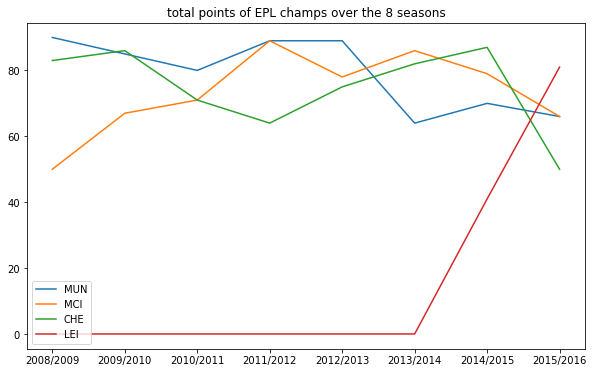

In [25]:
plt.figure(figsize=(10,6))
for key in EPL_teams_points_filtered.keys(): 
    plt.plot(seasons, EPL_teams_points_filtered[key], label = key)

plt.legend(loc='lower left')
plt.title('total points of EPL champs over the 8 seasons')
plt.show()

Visualizing the performance of the preimer league champs teams in terms of the total points over the 8 seasons, we can notice that some of them are on the roller coaster all the time (nature of the priemer league), but we can point out the Leicester City surprised us all in 2015-2016 season. we can aruge if the performance of man city was improving or not as it fluctuated quickly, but we can't deny that it was tough time for Man united. Really hoped that the dataset was updated to 2020 to see the spike of Liverpool and Mancity with Pep during the last couple of seasons 

Meanwhile, I can see this approach is more insightful in the la liga (spain). I will try it

In [26]:
LA_league = match_stats_df[match_stats_df.league_id == league_df[league_df.name == 'Spain LIGA BBVA'].id.values[0]]

In [27]:
LA_teams_points = {}
seas_n = len(seasons)
for i in range(len(seasons)):
    LA_league_s = LA_league[LA_league.season == seasons[i]].sort_values('date')
    #empty df to records the points of each round in the season
    LA_points_s = pd.DataFrame(index=LA_league_s.date.unique())
    #calculating the points
    LA_league_s.apply(lambda row: calc_point(row.home_team_goal, row.away_team_goal, row.date, row.home_team_api_id, row.away_team_api_id, LA_points_s), axis=1);
    #zeros for teams that didn't play in the early rounds or they lost
    LA_points_s.fillna(value=0, inplace=True)
    #cumlate the points over the rounds
    LA_points_s = LA_points_s.cumsum(axis = 0)
    #replace the team id with the team short name 
    LA_points_s.rename(columns=lambda val: team_df[team_df.team_api_id == val].team_short_name.values[0], inplace= True)
    for rec in zip(LA_points_s.tail(1).columns, LA_points_s.tail(1).values[0]):
        try:
            LA_teams_points[rec[0]][i] = rec[1]
        except:
            LA_teams_points[rec[0]] = [0] * seas_n
            LA_teams_points[rec[0]][i] = rec[1]

In [28]:
#I will choose the teams that participated in all the 8 seasons to visulaize
# LA_teams_points_filtered = {k:v for k, v in LA_teams_points.items() if len(v) == 8}
#I will choose the teams that won the league at least one time to visulaize
champs = list()
for i in range(len(seasons)):
    champs.append(list({k: v for k, v in sorted(LA_teams_points.items(), key=lambda item: item[1][i])}.keys())[-1])    

In [29]:
champs

['BAR', 'BAR', 'BAR', 'REA', 'BAR', 'AMA', 'BAR', 'BAR']

In [30]:
LA_teams_points_filtered = {k:v for k, v in LA_teams_points.items() if k in champs}

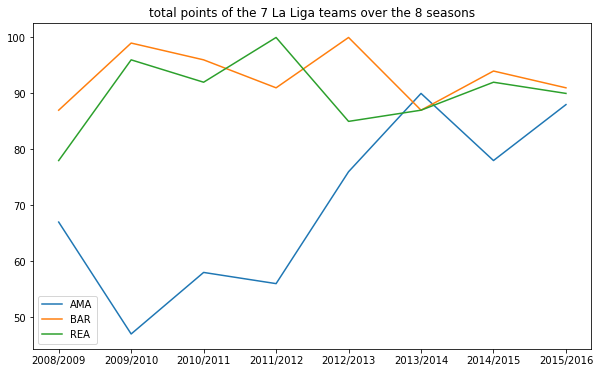

In [31]:
plt.figure(figsize=(10,6))
for key in LA_teams_points_filtered.keys(): 
    plt.plot(seasons, LA_teams_points_filtered[key], label = key)

plt.legend(loc='lower left')
plt.title('total points of the 7 La Liga teams over the 8 seasons')
plt.show()

We can point out how Diego Simeone took Atletico Madrid (AMA) to a different level. This is what we can all name it an improvement over time. The first season here (2008/2009) was the golden season, after which the performace decayed!
>
>**Note:** I'm not ignoring the data and start storytelling, but it is so exciting when data makes a certain part of the memory blink :"D

### Q2: What team attributes lead to the most victories?

Thinking about the team attributes that can lead to winning a league, first thing came in my mind is the FIFA radar chart. helper functions are adopted from [here](https://python-graph-gallery.com/391-radar-chart-with-several-individuals/)
>
> I will plot it for the top two teams in the season and this can be scaled for different teams in different leagues

In [32]:
#I order the points dictionary according to the last value (the points of the last season 15-16)
#to be able to pull the team attributes for the same date 2015 as it is not available for the first season
EPL_teams_points_filtered_ordered = {k: v for k, v in sorted(EPL_teams_points.items(), key=lambda item: item[1][-1])}

In [33]:
f_place = list(EPL_teams_points_filtered_ordered.keys())[-1]
s_place = list(EPL_teams_points_filtered_ordered.keys())[-2]

In [34]:
f_id = team_df[team_df.team_short_name == f_place].team_api_id.values[0]
s_id = team_df[team_df.team_short_name == s_place].team_api_id.values[0]

In [35]:
f_s_attr = team_attr_df[((team_attr_df.team_api_id == f_id) | (team_attr_df.team_api_id == s_id)) & (team_attr_df.date > '2015')]

In [36]:
f_s_attr = f_s_attr.set_index('team_api_id').rename({f_id: f_place, s_id: s_place})

In [37]:
f_s_attr = f_s_attr[['buildUpPlaySpeed',
'buildUpPlayPassing',
'chanceCreationPassing',
'chanceCreationShooting',
'defencePressure',
'defenceAggression']]

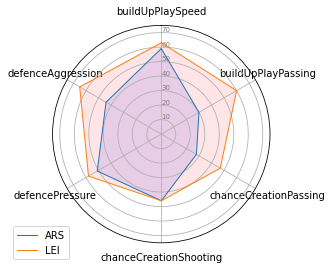

In [38]:
# number of variable
N = len(f_s_attr.columns)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], f_s_attr.columns)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30,40,50,60,70], ["10","20","30","40","50","60","70"], color="grey", size=7)
plt.ylim(0,75)
 
values=f_s_attr.loc[f_s_attr.index[0]].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=f_s_attr.index[0])
ax.fill(angles, values, 'b', alpha=0.1)
 
values=f_s_attr.loc[f_s_attr.index[1]].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=f_s_attr.index[1])
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

from the first look, we can point out the Leicester City introduced wonderful performance in all criteria. Also, the two teams were so close in two key features which are the buildup play speed and the defence pressure and this reflects how they were too close actually in the number of goals scored and received. LEI (68 scored, 36 received). ARS (65 scored, 36 received) [source](https://en.wikipedia.org/wiki/2015%E2%80%9316_Premier_League#League_table)

### Q3: Which players had the most penalties? 
I would go for the Calcio (Seria A) in Italy as it is well-known for the strong defense, let's say for season 2011-2012, 

In [39]:
SA_league = match_stats_df[match_stats_df.league_id == league_df[league_df.name == 'Italy Serie A'].id.values[0]]

In [40]:
SA_league_s1 = SA_league[SA_league.season == '2011/2012']

In [41]:
def count_penalties(goal_info, penal_dict):
    '''
    The function count the penalties for each player based on match stats
    Args:
        goal_info -> a tuble of goal info saves the home goal info and away goal info
            each tuble is composed of 4 values: time of the goal, id of the scorer, id of the assisstant, goal type
        penal_dict -> empty dict that would hold the ids of the penalties scorers and the number of penalties they had
    '''
    if goal_info != None:
        for rec in goal_info:
            for goal in rec:
                if goal[3] == 'p':
                    try:
                        penal_dict[goal[1]] = penal_dict[goal[1]] + 1
                    except:
                        penal_dict[goal[1]] = 0
                        penal_dict[goal[1]] = penal_dict[goal[1]] + 1

In [42]:
SA_penalties = {}
SA_league_s1.goals_info.apply(lambda val: count_penalties(val, SA_penalties));

In [43]:
top_penal_player_id = sorted(SA_penalties.items(), key=lambda item: item[1], reverse= True)[0][0]
top_penal_number = sorted(SA_penalties.items(), key=lambda item: item[1], reverse= True)[0][1]

In [44]:
top_penal_player_name = player_df[player_df.player_api_id == top_penal_player_id].player_name.values[0]

In [45]:
print(f'Top penalties scorer for Seria A in season 11/12 was {top_penal_player_name} with total {top_penal_number} penalties')

Top penalties scorer for Seria A in season 11/12 was Zlatan Ibrahimovic with total 10 penalties


I like what I see! This source [here](https://www.transfermarkt.com/zlatan-ibrahimovic/elfmetertore/spieler/3455/saison_id/2011/wettbewerb_id/IT1#tore) confirms the number and describes those 10 matches' report

## Conclusion and comments

> Although the dataset is quite extensive, it is a rich environment to explore various techniques. As a final comment on the proposed questions:
>
> Q1: The analysis introduced very good insights about the performance as long as it is measured in terms of total points at the end of the season and pointed out how LEI city improved his perfromance in that manner. But there are some limitations for this, as the performance can't be only measured based on the total number of points. there are multiple additional aspects such as the number of championships each team is participating in (LEI dedicating all his power for the league is different from another team divides his effort on league and champions), besides other perfromance criteria such as the longest win streak, the longest clean sheet etc.
> Also... we can't judge the performance and ignoring that during the 8 seasons of interest, some teams rocked more than one time like MAN united.
>
> Q2: the comparison between the two teams was too close. My comment here (which can be considered as limitation) is that the team attributes data are pulled from FIFA API. it was not monitored though the season. So, maybe the stats are biased towards the champion with so many buffs (boosts). I am saying this because LEI was not that huge as the stats show, and his main strategy was to let the possession for the other team and depend on the counterattacks making use of the speeds of Mahrez and Vardy. For future analysis, I may work (or suggest working) on proving this using the cleaned possession values
>
> Q3: The top penalties scorer can be scaled to all the seasons and leagues. Also, for futre work, we can inspect the relation between the player stat and the goal types he has. Still will be biased stats as FIFA boosts the stats of the well-known football starts :"D